<h1 align=center style="color: #005496; font-size: 4.2em;">TensorFlow</h1>
<h2 align=center>Laboratory on Neural Networks</h2>

***



## Introduction

A few years back, Google has open-sourced its machine learning framework: **TensorFlow**. Since then, it has become one of the most used tools in machine learning, both for research purposes and for production systems. TensorFlow is very flexible and can handle a wide range of neural architectures.

In this lecture we will see how we can build a simple Neural Network capable of categorizing images from the *MNIST* dataset into digits. This tutorial 
is a mix of some guides hosted on the [tensorflow website](https://www.tensorflow.org/tutorials).

This lecture assumes familiarity with the Python programming language and the libraries we have seen in the previous lecture: Numpy, Matplotlib and Scikit-learn.


## Google Colab

Google Colab is a  cloud service based on Jupyter  that enables to execute notebooks in the cloud, using resources from Google's datacenters.
Google even provides limited access to GPU, in order to accelerate tasks such as 
deep learning.

## References

- https://www.tensorflow.org
- https://www.tensorflow.org/tutorials/quickstart/beginner
- https://www.tensorflow.org/tutorials/quickstart/advanced
- http://yann.lecun.com/exdb/mnist/

# Object-oriented programming in Python
Before start playing with tensorflow we need to briefly introduce objects in Python.




## Classes and Objects
Python is an object oriented programming language.
Almost everything in Python is an object, with its properties and methods.

An object is a combination of variables and functions used to perform 
operations over them. Each object is an instance of a class.

A class is like an object constructor, or a "blueprint" for creating objects.
A class defines both object's variables (usually referred as `attributes`) and
funtions (referred as `methods`) that will operate over them.

Among many others, there exists a special method, the __\_\_init\_\___ method.
In the __\_\_init\_\___ method  we define and initialize the 
attributes of the objetcs we will create starting from the class.

As the language mandates, the first argument of each method of a class 
is `self`, which is a pointer to the instance of the class itself.
This enables to perform computation involving attributes:

In [1]:
class Person: # the class definition
  def __init__(self, p_name, p_age):
    self.name = p_name # create some attributes
    self.age = p_age

  def hello(self, greetings="Hello"): # define a method
    print(greetings + " my name is " + self.name)

p1 = Person("John", 36) # create object from class Person
print(p1.age)
p1.hello(greetings="Hi")
p1.hello()

36
Hi my name is John
Hello my name is John


Then we can reuse the class to create other persons

In [2]:
p2 = Person("Alice", 27)

print(p2.age)
p2.hello()

27
Hello my name is Alice


## Inheritance

Inheritance enables us to define a class that inherits all the methods and attributes from another class.

The __parent__ class is the class being inherited from, also called base or super class.

The __child__ class is the class that inherits from another class, also called derived  or sub class.

We can specify the parent class by putting its name 
in brackets after the name of the child class.

In the child's __\_\_init\_\___ method we must call the parent's __\_\_init\_\___
method, in order to initialize the parent correctly. This can 
be done by using the `super()` function

In [3]:
class Student(Person): # Student inherits from Person
  def __init__(self, name, age, year):
    super().__init__(name, age) # call __init__ method of the parent class
    self.graduationyear = year

  def welcome(self):
    print("Welcome", self.name, "to the class of", self.graduationyear) 

s1 = Student("Bob", 24, 2021)

print(s1.age) # inherited from Person
s1.hello(greetings="Hi") # inherited from Person 

print(s1.graduationyear)
s1.welcome()


24
Hi my name is Bob
2021
Welcome Bob to the class of 2021


# TensorFlow

Let's dive into how to declare and train a Neural Network with *TensorFlow*.

Instruct Google Colab to load TensorFlow __version 2__:

In [4]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


Import TensorFlow  into your program:

In [5]:
import tensorflow as tf

tf.random.set_seed(0) # set seed for reproducibility, still not deterministic if a GPU is used


As it was for the numpy library (which we used in the last tutorial), 
even  TensorFlow has its basic data structure, called __Tensor__. 
A Tensor is the equivalent of the numpy array, a fixed-size structure containing
an ordered collection of homogeneous data. 


In [6]:
t = tf.convert_to_tensor([1,2,3,4])
t

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 2, 3, 4], dtype=int32)>

There are many ways to declare tensors, many of them quite 
similar to numpy:

In [7]:
import numpy as np
a = np.arange(5)
t = tf.range(5)

print(a)
print(t)

print(a.shape)
print(t.shape)

[0 1 2 3 4]
tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int32)
(5,)
(5,)


The library offers easy ways to switch between Tensors and numpy arrays:

In [8]:
an_array = np.array([1,2,3])
a_tensor = tf.convert_to_tensor(an_array) # from array to tensor

another_array = a_tensor.numpy() # from tensor to array

print(an_array)
print(a_tensor)
print(another_array)

[1 2 3]
tf.Tensor([1 2 3], shape=(3,), dtype=int64)
[1 2 3]


Tensors can be directly used within the numpy library

In [9]:
np.sqrt(an_array * a_tensor)

array([1., 2., 3.])

## MNIST dataset

*MNIST* is a dataset containing labelled images of handwritten digits. This dataset is similar to the *digits* dataset we have seen in the previous lecture, but the images here are larger, 28 by 28 pixels.

We can use TensorFlow directly to download and read the MNIST data:

In [23]:
mnist = tf.keras.datasets.mnist

(data_train, targets_train), (data_test, targets_test) = mnist.load_data()

The data instances in MNIST are images represented by  arrays contaning 784 numbers between 0 and 255, i.e. the gray scale relative intensity of the pixels (0 means white, 255 means black). Later we will  normalize them, obtaining values between 0 and 1. The shape of the loaded data is
(number of images, 28, 28).

<img src="https://www.tensorflow.org/images/MNIST-Matrix.png" width="600px" />

***

MNIST already comes with a train-test split. The training data is a *numpy array* of 60000 images, while the test data contains 10000 images.

<img src="https://i.imgur.com/vNWCOld.png" width="600px"/>


***

In the current version of Tensorflow the labels are encoded 
as categorical values (integers from 0 to 9). For this tutorial we will use the so-called
"one-hot" representation. Each label `y` is a vector of 10 0-1 elements, in which only the position associated with the true digit is set to 1, the others are set to 0. Thus, the training labels will be encoded as a  tensor of shape (number of images, 10).

<img src="https://i.imgur.com/4sgGtT1.png" width="650px" />

Once loaded, we can visualize the data using Matplotlib

<Figure size 432x288 with 0 Axes>

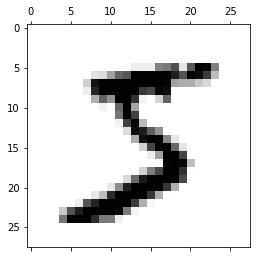

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.gray()
plt.matshow(255 - data_train[0]) # 255 - x simply inverts the fading direction of the image
plt.show()

While the label is:

In [25]:
targets_train[0]

5

We can use the `tf.one_hot` function in order to obtain the one hot encoding

In [26]:
one_hot = tf.one_hot(targets_train[0], 10) # we must specify the number of classes, 10 for MNIST
one_hot

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)>

Let's cast the data to floating points, normalize and reshape it (we need to add an empty dimension at the end, in order to use it later to train  our neural networks)

In [27]:
                 
x_train = tf.cast(data_train, tf.float32) / 255.0
x_test = tf.cast(data_test, tf.float32) / 255.0

# Add a fourth dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

x_train.shape

TensorShape([60000, 28, 28, 1])

In [28]:
y_train = tf.one_hot(targets_train, 10)
y_test = tf.one_hot(targets_test, 10)

## Softmax Regression

The first thing we are going to implement using TensorFlow is a simple softmax regression model to predict the digits from the images. Softmax regression is a generalization of Logistic Regression to multi-class classification.

In softmax regression we define a linear model for each possible class. These models provide evidence supporting the image `x` being of the particular class `i`:

\begin{equation}
    \theta_i = \sum_{1 \le j \le 784} W_{i,j} \cdot x_j + b_i
\end{equation}

A softmax function is then applied to each linear model in order to get the probability $y_i$ of the image being of class `i`:

\begin{equation}
    y_i = \text{softmax}(\theta_i) = \frac{e^{\theta_i}}{\sum_{j} e^{\theta_j}}
\end{equation}

This is a schematic view of the operations we are a doing:

<img src="https://www.tensorflow.org/images/softmax-regression-scalargraph.png" width="400px" />

***

Spelling out the equations of our model:

<img src="https://www.tensorflow.org/images/softmax-regression-scalarequation.png" width="400px" />

***

The vectorized form:

<img src="https://www.tensorflow.org/images/softmax-regression-vectorequation.png" width="400px" />

***

The vectorized equation is therefore the following:

\begin{equation}
    y = \text{softmax}(W \cdot x + b)
\end{equation}

Where $y$ is a $1 \times 10$ column vector, $W$ is a $10 \times 784$ matrix, $x$ is a $1 \times 784$ column vector and $b$ is a $1 \times 10$ column vector. While we used column vectors for ease of exposition, in the implementation is much more convenient to use row vectors for $x$, $b$ and $y$. Hence, the matrix `W` in the code below will be of shape (784, 10). Let's now dive into the definition of this perceptron with TensorFlow.

First we need to import some objects that we will use to compose
our models:

In [29]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Softmax, Flatten

Then we can start defining our custom perceptron.

In Tensorflow, in order to create a custom layer or network we must
extend the class `tensorflow.keras.Model`, by defining
all the weights (or layers) and the operations of our model.
Our network will be a child class of  `tensorflow.keras.Model`, inheriting 
all the capabilities of that class, for instance the ability to 
perform automatic gradient computation over its parameters.

Let's define our perceptron. In the __\_\_init\_\___ method we need to declare our matrix of weights `self.W` and biases `self.b`, plus two more layers: a  `Flatten` layer, which is used to trasform
images, represented as 28x28 matrices, to vectors of 784 elements, 
and a `Softmax` layer that, as the name suggests, will compute the softmax over 
the output of the perceptron.

In the __call__ method we use the components we declared in order to
compose the series of operations needed to perform inference over 
a batch of examples `x`, represented as a tensor whose shape at runtime will be 
(batch size, 28, 28, 1). First we apply the flatten layer, in order to obtain
a batch with shape (batch size,  784), then we perform the matrix multiplication
with `self.W` and the addition of the bias vector `self.b`.

The result of the matrix multiplication has shape (batch size, 10), while 
the bias vector has shape (1, 10). In order to execute this addition ,
tensorflow performs an automatic  *broadcasting* of the biases by repetition, in order
to obtain the same shape of the other operand. You can find 
all the broadcasting rules in the [documentation](https://www.tensorflow.org/xla/broadcasting).


In [30]:
class MnistPerceptron(Model): # inherit from Model
  def __init__(self):
    super().__init__() # initialize Model
    self.flatten = Flatten() # used to flatten pixels of images
    self.W = tf.Variable(tf.zeros([784, 10])) # declare weights with shape :(748, 10)
    self.b = tf.Variable(tf.zeros([1, 10]))   # declare biases, with shape :(1, 10)
    self.softmax = Softmax()
    

  def call(self, x,training=False): 
    # the  training argument is unused in this model, we will need it later
                                                  
    flat = self.flatten(x) # flatten images   
            
    multiplied = tf.matmul(flat, self.W) # matmul, output shape : (batch, 10)
    # we can equivalently do:
    #multiplied = tf.transpose(tf.matmul(tf.traspose(self.W), tf.traspose(flat)))

    fwded = multiplied + self.b # broadcast self.b to (batch, 10) and add   

    prob = self.softmax(fwded) # softmax              
    return prob

# Create an instance of the model
perceptron = MnistPerceptron()

## Training

After we define the model, we want to train it using the MNIST data, using gradient descent. To do so, we first need to define a **loss function**. For this task we are going to use the *cross-entropy* loss:

\begin{equation}
    H_{y}(\hat{y}) = - \sum_i y_i \log(\hat{y}_i)
\end{equation}

Where $\hat{y}$ is the distribution predicted by our model and $y$ is the true probability distribution of the classes (i.e. the one-hot vector).


In [31]:
perceptron_loss = tf.keras.losses.CategoricalCrossentropy()

Then we must create a `Dataset`, starting from the MNIST data, that we will use to train end evaluate our models. A Dataset is an object that can be used to 
organize our raw data in batches of examples.

Let's create a train and test datasets. Then we will be able to iterate over them, obtaining a batch at each iteration that we will use to perform gradient descent. 

In [32]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(100)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(50)

Choose an optimizer for training. 
In this case we will use Stocastic Gadient Descent (SGD) with a leraning rate of 0.01

In [33]:
perceptron_optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over different batches and then print the overall result.

In [34]:
train_loss_metric = tf.keras.metrics.Mean()
train_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()

test_loss_metric = tf.keras.metrics.Mean()
test_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()

Then we can define a series of functions that we will use to train our model.

Our training framework is an iterative procedure that starts by sampling a
batch of examples from the training set, coupled with their labels. 
The data is fed to the model, whose predictions are matched with the
true labels via a loss function. Then the gradient of the loss with
respect to the parameters of  the model is computed, and used to 
update the parameters (following the directions in which it decreases).

The tensorflow library is able to automatically compute these 
operations. In order to
do this we must create a disposable object, called __tape__.
This tape keeps track of the operations performed during inference
and computes the gradient with respect the loss function. 
The gradient is then passed to the optimizer in order to
perform the update. 

As last operation we update our accumulators to keep track of the 
loss and accuracy metrics.


In [35]:
def train_step(images, labels, model, loss_fn, optimizer):
  with tf.GradientTape() as tape: # all the operations within this scope will be recorded in tape
    predictions = model(images, training=True)
    loss = loss_fn(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss_metric(loss)
  train_accuracy_metric(labels, predictions)

We can then use our train step in order to perform training, by creating a training loop that iterates for a given number of times 
(usually referred as *epochs*) trought
the dataset, printing the metrics at the end of each step.

In [36]:
from datetime import datetime

def train_loop(epochs, train_ds, model, loss_fn, optimizer):
  for epoch in range(epochs):
      # reset the metrics for the next epoch
    train_loss_metric.reset_states()
    train_accuracy_metric.reset_states()

    start = datetime.now() # save start time 
    for images, labels in train_ds:
      train_step(images, labels, model, loss_fn, optimizer)

    template = 'Epoch {}, Time {}, Loss: {}, Accuracy: {}'
    print(template.format(epoch+1,
                          datetime.now() - start,
                          train_loss_metric.result(),
                          train_accuracy_metric.result()*100))



Now we are ready to perform training

In [37]:
EPOCHS = 10
train_loop(EPOCHS, train_ds, perceptron, perceptron_loss, perceptron_optimizer)

Epoch 1, Time 0:00:03.605029, Loss: 1.1449335813522339, Accuracy: 80.3550033569336
Epoch 2, Time 0:00:03.564252, Loss: 0.6415690183639526, Accuracy: 85.72833251953125
Epoch 3, Time 0:00:03.609129, Loss: 0.5356609225273132, Accuracy: 87.04499816894531
Epoch 4, Time 0:00:03.564497, Loss: 0.48453617095947266, Accuracy: 87.8066635131836
Epoch 5, Time 0:00:03.611892, Loss: 0.45318278670310974, Accuracy: 88.3066635131836
Epoch 6, Time 0:00:03.615754, Loss: 0.43141448497772217, Accuracy: 88.69332885742188
Epoch 7, Time 0:00:03.619934, Loss: 0.41525769233703613, Accuracy: 88.97167205810547
Epoch 8, Time 0:00:03.578993, Loss: 0.4026186168193817, Accuracy: 89.22000122070312
Epoch 9, Time 0:00:03.670211, Loss: 0.3923594653606415, Accuracy: 89.45000457763672
Epoch 10, Time 0:00:03.774342, Loss: 0.38381922245025635, Accuracy: 89.62000274658203


## Evaluation

Let's now evaluate our model on the test set. We need to define another couple of functions, in order to compute the metrics over each batch and then to 
aggregate the results.

In [38]:
def test_step(images, labels, model, loss_fn):
  predictions = model(images, training=False)
  t_loss = loss_fn(labels, predictions)

  test_loss_metric(t_loss)
  test_accuracy_metric(labels, predictions)

In [39]:
def test_loop(test_ds, model, loss_fn):
    # reset the metrics for the next epoch
  test_loss_metric.reset_states()
  test_accuracy_metric.reset_states()
 
  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels, model, loss_fn)

  template = 'Test Loss: {}, Test Accuracy: {}'
  print(template.format(test_loss_metric.result(),
                        test_accuracy_metric.result()*100))

Then we can perform evaluation of our trained perceptron

In [40]:
test_loop(test_ds, perceptron, perceptron_loss)

Test Loss: 0.36067456007003784, Test Accuracy: 90.36000061035156


Good! Our model works (sort of). These performance on MNIST are way too low. The state-of-the-art on this dataset has an accuracy of $0.9979$. Let's try to achieve a better accuracy by refining a bit our model.

## Deep architectures

<p>
We are now going to define a deep neural network capable of classifying digits much better than the shallow softmax we used before. We are going to use two convolutional layers alternated with 2 max pool layers, followed by a fully connected layer regularized with dropout, and finally we'll get predictions using again a softmax layer. Here you see a schematic view of the architecture (bottom up). 
</p>

<img src="https://i.imgur.com/fra8hbB.png" style="width: 350px" />

***

### Fully Connected Layer
In a fully connected layer each neuron is connected with each neuron of the previous layer. This is the most straightforward way to implement a Neural Network.

<img src="https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1547672259/3_qwv5gr.png" width="750px" />

***


### Convolutional layer

Convolutional Neural Networks are based on a method for extracting meaningfull features from images, exploiting locality and parameter sharing between "close" pixels. In particular, a convolutional layer takes as input a matrix and divides it into smaller "patches". It outputs a number of features for each patch. The resulting tensor will be similar to the one in the following picture.

<img src="https://upload.wikimedia.org/wikipedia/commons/6/68/Conv_layer.png" width="400px" />
<img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif" width="250px" />

Applying a convolution reduces the height and the width of the 
input image. This effect is not always desirable. 
In order to avoid it, we must add some empty data around our images.
This data (usually containing zeros) is called *padding*



<img src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/same_padding_no_strides.gif" width="400px" />


***

### Max pool layer

The max pool layer is a filter that is used to reduce the number of the input dimensions between two convolutional layers. It is useful for dimensionality reduction, it avoids overfitting, etc. The following is a simple example:

<img src="http://www.wildml.com/wp-content/uploads/2015/11/Screen-Shot-2015-11-05-at-2.18.38-PM.png" width="400px" />

***

### ReLU layer

Rectified Linear Unit (ReLU) is a particular activation function of the type: $max(0, \theta)$. ReLUs have become very wide spread thanks to the fact, differently from sigmoids, that they do not saturate the gradient when used with backpropagation. This has enabled neural networks to become deeper and to increase their representational power. The following image compares several activation functions and their gradients.

<img src="https://d9johdpvmzlgp.cloudfront.net/images/Blog/af.jpg" width="700px" />

***

### Dropout

Dropout is a regularization technique for neural networks. When using dropout, we set a probability for dropping random nodes from the networks at each gradient descent step. In this way, the network is going to learn a more robust model, not relying too much on a single node for a prediction. In some sense, using dropout we are "sampling" a lot of different networks and learning them, and finally we are left with the "average" network, which is less susceptible to outliers. Dropouts also helps in avoiding overfitting.

<img src="https://pgaleone.eu/images/dropout/dropout.jpeg" width="400px" />

***

Let's start by defining two modules, one encoding a convolutional layer, another for the fully connected layer.

In [41]:
class MnistConvolutional(Model):
  def __init__(self, in_channels, out_channels, size):
    super().__init__() # setup the moedl basic functionalities (mandatory)
    initial = tf.random.truncated_normal([size, size, in_channels, out_channels], stddev=0.1)
    self.filters = tf.Variable(initial) # create weights for the filters

  def call(self, x):
    res = tf.nn.conv2d(x, self.filters, 1, padding="SAME")
    return res

class MnistFullyConnected(Model):
  def __init__(self, input_shape, output_shape):
    super().__init__() # initialize the model
    self.W = tf.Variable(tf.random.truncated_normal([input_shape, output_shape], stddev=0.1)) # declare weights 
    self.b = tf.Variable(tf.constant(0.1, shape=[1, output_shape]))  # declare biases
    
  def call(self, x):
    res = tf.matmul(x, self.W) + self.b 
    return res


Then we can define our complete network.

Note that, due to the presence of the dropout,
in this case the behavior of the network at evalution phase
is different than the one at training phase.

During evaluation, the dropout layer must rescale the output 
instead of randomly dropping part of it. For this reason, 
the dropout at inference time takes in input an argument `training`
that controls the behavior of the layer. We can pass to it the 
value our network receives from the caller, enabling us to 
control it from the outside (see `treain_step` and `test_step` functions).

In [42]:
from tensorflow.keras.layers import MaxPool2D, Dropout

class MnistDeepModel(Model):
  def __init__(self):
    super().__init__()                            #input shape: (batch, 28, 28, 1)
    self.conv1 = MnistConvolutional(1, 32, 5)  # out shape : (batch, 28, 28, 32)
    self.pool1 = MaxPool2D([2,2])                 # out shape : (batch, 14, 14, 32)
    self.conv2 = MnistConvolutional(32, 64, 5) # out shape : (batch, 14, 14, 64)
    self.pool2 = MaxPool2D([2,2])                 # out shape : (batch, 7, 7, 64)
    self.flatten = Flatten()                      # out shape : (batch, 7*7*64)
    self.fc1 = MnistFullyConnected(7*7*64, 1024)  # out shape : (batch, 1024)
    self.dropout = Dropout(0.5)                   # out shape : unchanged
    self.fc2 = MnistFullyConnected(1024, 10)      # out shape : (batch, 10)
    self.softmax = Softmax()                      # out shape : unchanged

  def call(self, x, training=False):
    x = tf.nn.relu(self.conv1(x))
    x = self.pool1(x)
    x = tf.nn.relu(self.conv2(x))
    x = self.pool2(x)

    x = self.flatten(x)
    x = tf.nn.relu(self.fc1(x))

    x = self.dropout(x, training=training) # behavior of dropout changes between train and test
    
    x = self.fc2(x)
    prob = self.softmax(x)
    
    return prob

# Create an instance of the model
network = MnistDeepModel()

Choose an optimizer and loss function for training: 

In [43]:
network_loss = tf.keras.losses.CategoricalCrossentropy()

network_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

Train the model using the same helper function we created for the perceptron

In [44]:
EPOCHS = 10
train_loop(EPOCHS, train_ds,  network, network_loss, network_optimizer)

Epoch 1, Time 0:01:05.860249, Loss: 0.5832840800285339, Accuracy: 83.65332794189453
Epoch 2, Time 0:01:08.777876, Loss: 0.15093374252319336, Accuracy: 95.40332794189453
Epoch 3, Time 0:01:08.087077, Loss: 0.09910079836845398, Accuracy: 96.8949966430664
Epoch 4, Time 0:01:08.021989, Loss: 0.07261708378791809, Accuracy: 97.79000091552734
Epoch 5, Time 0:01:08.202539, Loss: 0.060922954231500626, Accuracy: 98.04666900634766
Epoch 6, Time 0:01:08.442773, Loss: 0.04813766852021217, Accuracy: 98.50833129882812
Epoch 7, Time 0:01:08.658587, Loss: 0.039528004825115204, Accuracy: 98.75333404541016
Epoch 8, Time 0:01:08.533909, Loss: 0.03593515604734421, Accuracy: 98.80833435058594
Epoch 9, Time 0:01:14.251893, Loss: 0.03098743036389351, Accuracy: 99.038330078125
Epoch 10, Time 0:01:09.305129, Loss: 0.027298955246806145, Accuracy: 99.06999969482422


Then perform evaluation over the trained network

In [45]:
test_loop(test_ds, network, network_loss)

Test Loss: 0.026196477934718132, Test Accuracy: 99.1500015258789


The image classifier is now trained to ~99% accuracy on this dataset. 
By selecting a better set of hyperparameters 
(number of epochs, batch size, number of neurons in the various  layers, number of layers, etc..)
we could obtain even better results. 
To learn more, read the [TensorFlow tutorials](https://www.tensorflow.org/tutorials).

